In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

from urllib.request import urlopen
from unidecode import unidecode

import pandas as pd
import numpy as np
import itertools
import re
import os

import pymmwr as pm
import urllib

import sys

sys.path.insert(0, '../')

from global_config import config
from itertools import chain

results_dir   = config.get_property('results_dir')
data_dir      = config.get_property('data_dir')

plt.rc('font', size=15)

In [3]:
data_df = pd.read_csv(os.path.join(data_dir, "processed_data_us.csv"), parse_dates=['date'])

dates_forecasts = data_df.date[11:].values

path_to_save_fcast0 = os.path.join(results_dir, "forecast", "arima")
path_to_save_fcast1 = os.path.join(results_dir, "forecast", "sarima")
path_to_save_fcast2 = os.path.join(results_dir, "forecast", "eakf_model1")
path_to_save_fcast3 = os.path.join(results_dir, "forecast", "eakf_model2")
path_to_save_fcast4 = os.path.join(results_dir, "forecast", "eakf_model3")

list_paths = [path_to_save_fcast0, path_to_save_fcast1, path_to_save_fcast2, path_to_save_fcast3, path_to_save_fcast4]


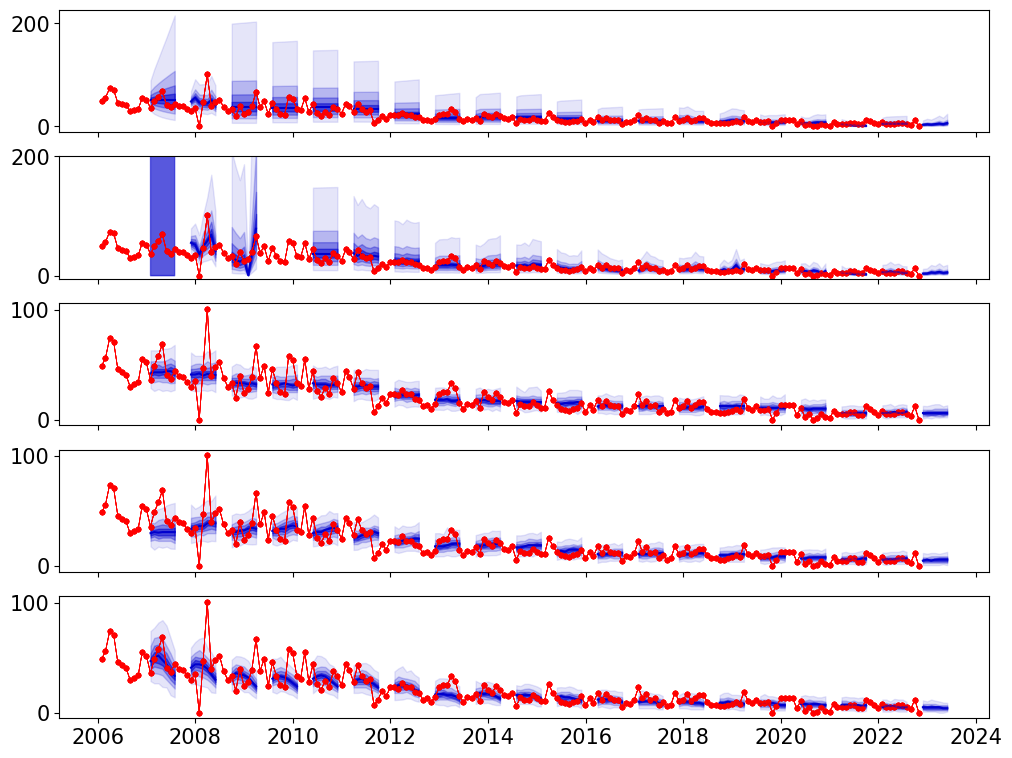

In [21]:
viz_dates = dates_forecasts[::10]

fig, ax = plt.subplots(5, 1, figsize=(12, 9.2), sharex=True, sharey=False)
for date_plot in viz_dates:
    ds =  pd.to_datetime(date_plot).strftime('%Y-%m-%d')
    for idx_axi, axi in enumerate(ax.flatten()):
        forecast_df = pd.read_csv(os.path.join(list_paths[idx_axi], f"{ds}.csv"), parse_dates=["date"]).iloc[:7]
        axi.plot(data_df.date, data_df["total"], label="IMD", color="red", marker=".", alpha=0.3, lw=0.5)
        axi.plot(forecast_df.date, forecast_df["median"], label=f"{date_plot}", color="mediumblue")
        axi.fill_between(forecast_df.date, forecast_df["up_97.5"], forecast_df["low_97.5"], alpha=0.1, color="mediumblue")
        axi.fill_between(forecast_df.date, forecast_df["up_75"], forecast_df["low_75"], alpha=0.2, color="mediumblue")
        axi.fill_between(forecast_df.date, forecast_df["up_50"], forecast_df["low_50"], alpha=0.3, color="mediumblue")
        axi.fill_between(forecast_df.date, forecast_df["up_25"], forecast_df["low_25"], alpha=0.5, color="mediumblue")

        ylow, yup = axi.get_ylim()
        if yup > 1000:
            axi.set_ylim((-5, 200))


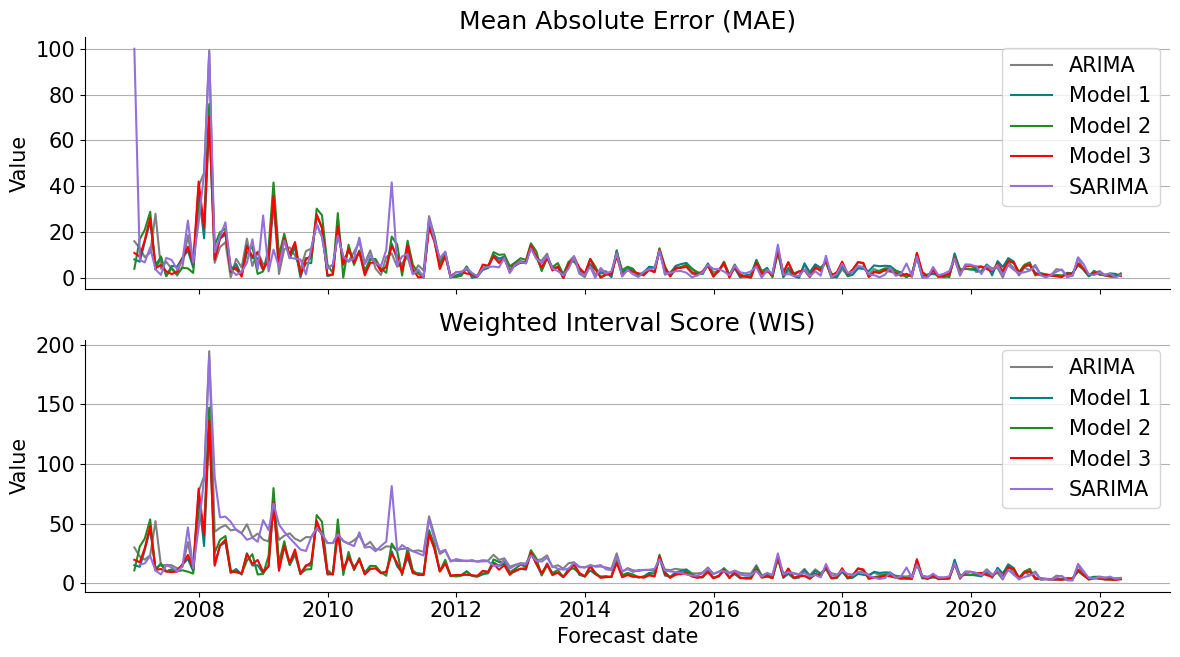

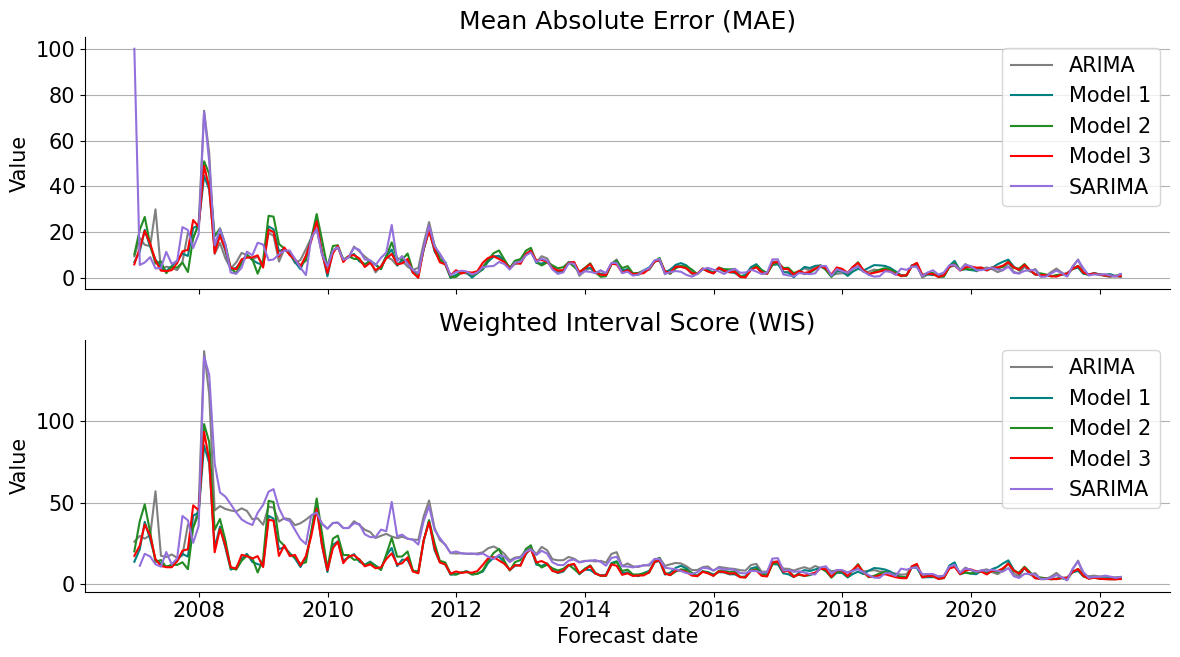

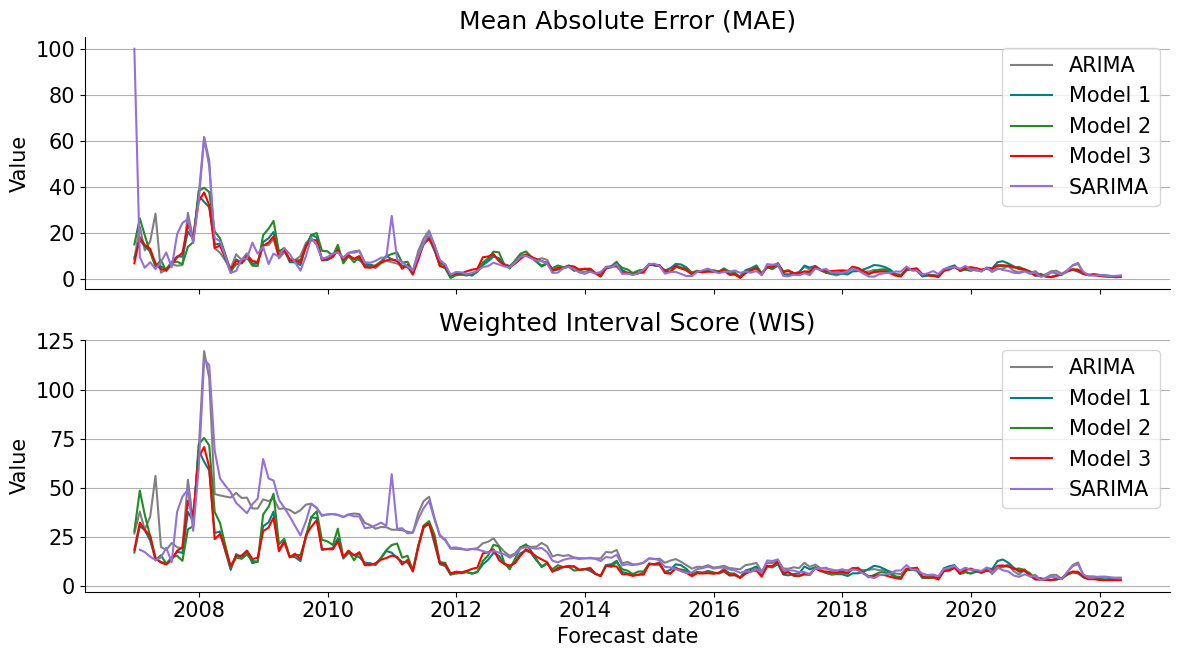

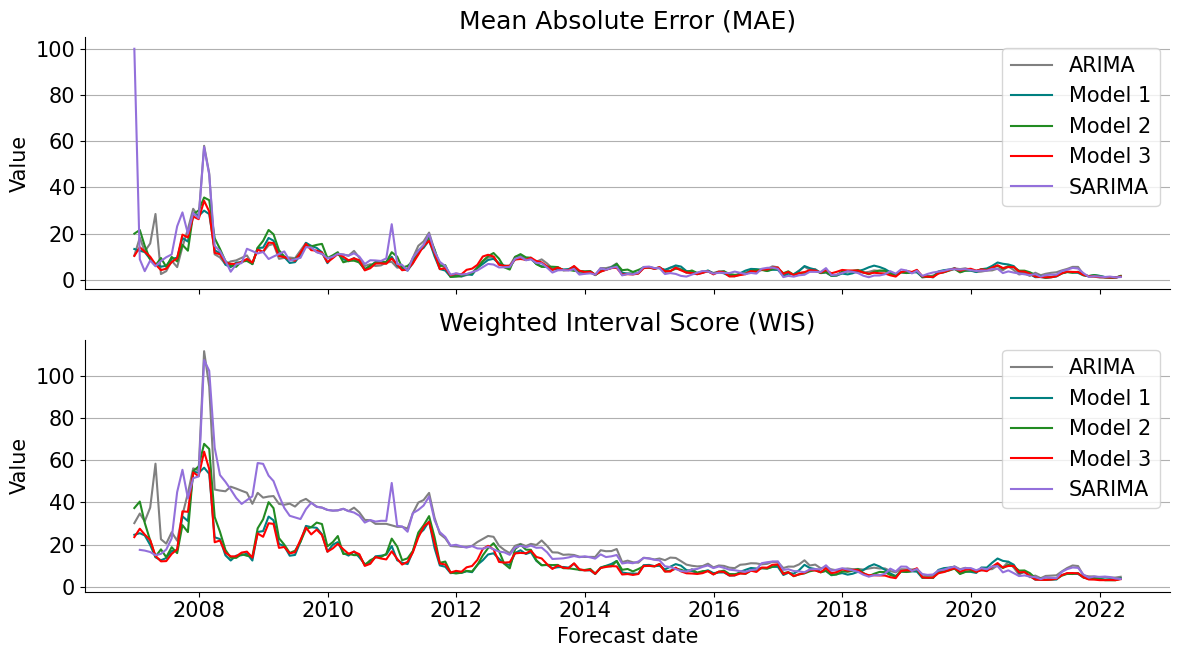

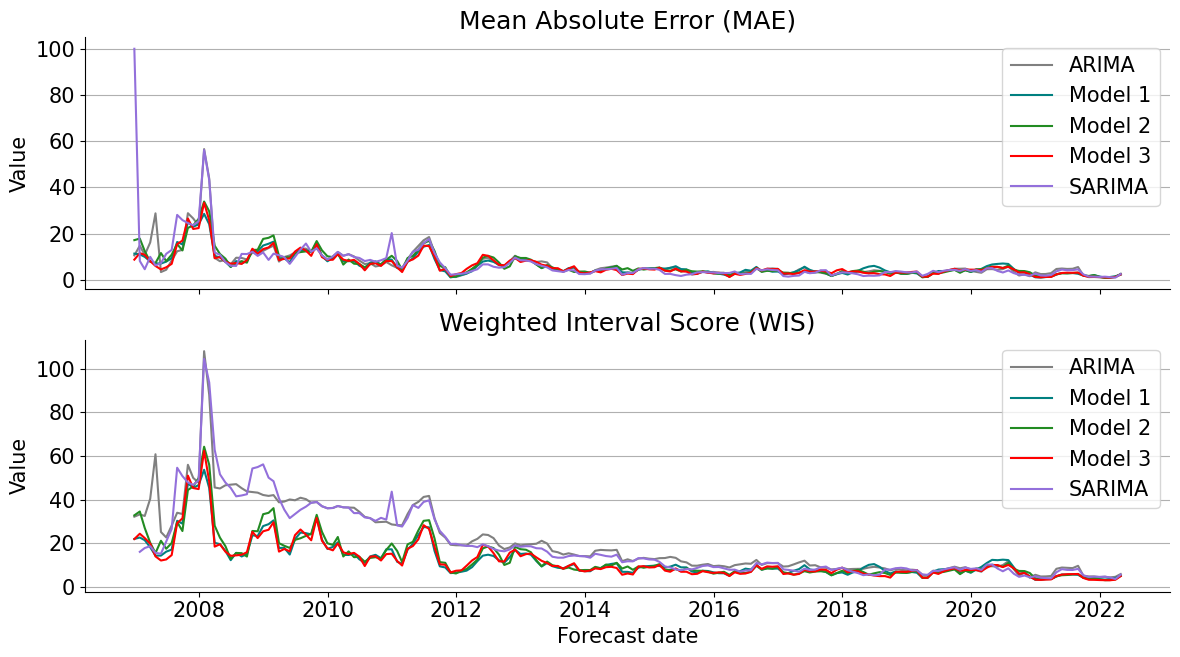

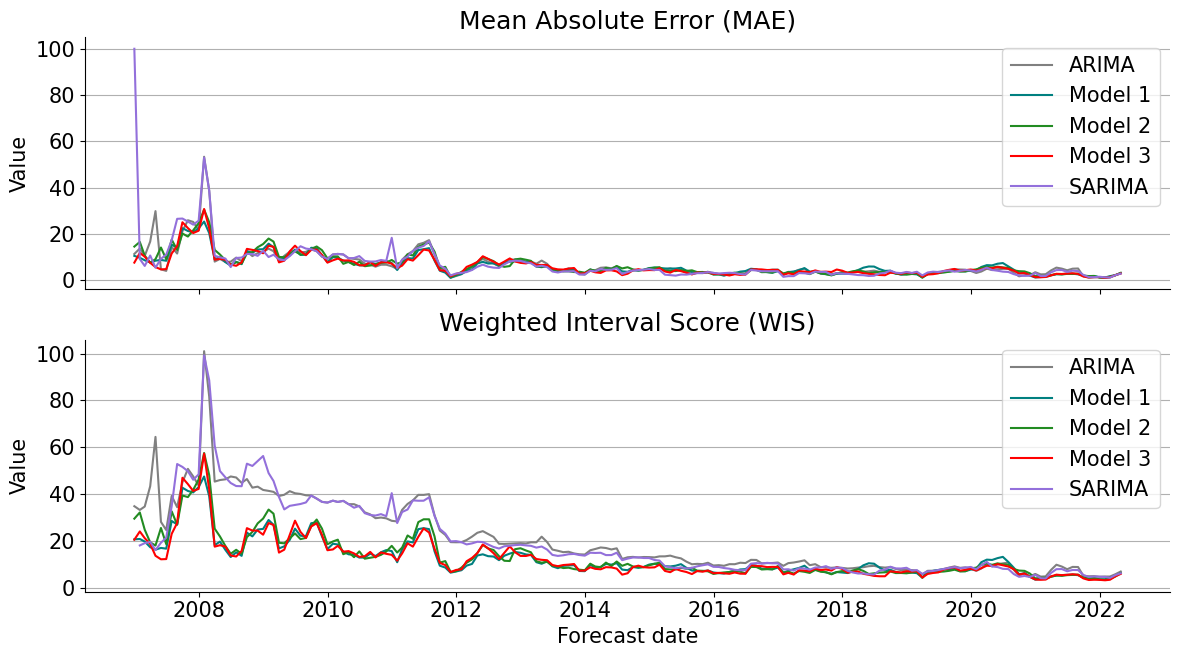

In [70]:
import seaborn as sns
evals_df = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation", "BD_scores.csv")).drop(columns=[ "error"])
evals_df["frsct_date"] = pd.to_datetime(evals_df["frsct_date"])

evals_df["mae"] = np.minimum(evals_df["mae"], 100)

evals_df["method"] = evals_df["method"].replace({"arima": "ARIMA", "sarima": "SARIMA", "eakf_model1": "Model 1", "eakf_model2": "Model 2", "eakf_model3": "Model 3"})

eval_horizon = ["1m", "2m", "3m", "4m", "5m", "6m"]

eh = eval_horizon[-1]

for eh in eval_horizon:
    colors  = ["gray", "teal", "forestgreen", "red", "mediumpurple"]

    fig, ax = plt.subplots(2, 1, figsize=(14, 7.2), sharex=True, sharey=False)

    sco_df = evals_df[evals_df["eval_horizon"] == eh]

    sns.lineplot(x="frsct_date", y="mae", hue="method", markers="method", palette=colors, data=sco_df, ax=ax[0])
    sns.lineplot(x="frsct_date", y="wis", hue="method", markers="method", palette=colors, data=sco_df, ax=ax[1])

    sns.despine()
    ax[0].grid(axis="y")
    ax[1].grid(axis="y")


    ax[0].set_title("Mean Absolute Error (MAE)")
    ax[1].set_title("Weighted Interval Score (WIS)")

    ax[0].set_ylabel("Value")
    ax[1].set_ylabel("Value")

    ax[0].legend(title=None)
    ax[1].legend(title=None)

    ax[-1].set_xlabel("Forecast date")

    fig.savefig(os.path.join(results_dir, "figures", "reviews", "individual_performance", f"ind_eval_{eh}.png"), bbox_inches="tight", dpi=300)


In [72]:
sco_df["method"].isin(["Model 1", "Model 2", "Model 3"])


5       False
11       True
17       True
23       True
29      False
        ...  
5525    False
5531     True
5537     True
5543     True
5549    False
Name: method, Length: 925, dtype: bool

In [74]:
sco_df["method"].isin(["Model 1", "Model 2", "Model 3"]).values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

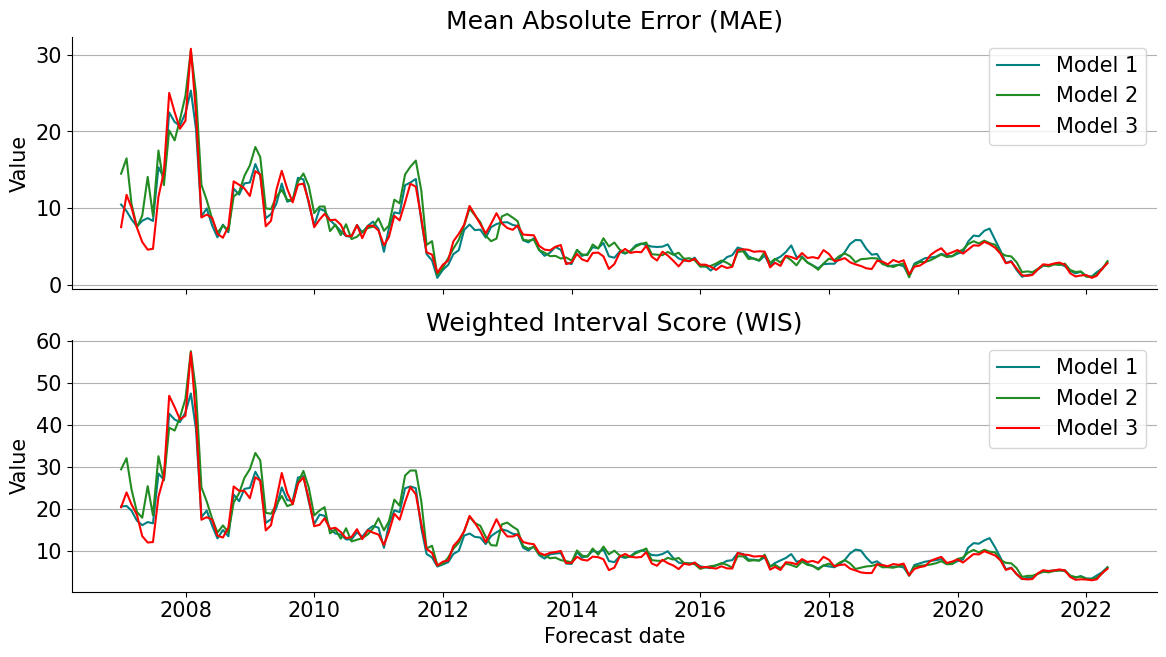

In [75]:
fig, ax = plt.subplots(2, 1, figsize=(14, 7.2), sharex=True, sharey=False)

sco_df = evals_df[evals_df["eval_horizon"] == "6m"]
sco_df = sco_df.iloc[sco_df["method"].isin(["Model 1", "Model 2", "Model 3"]).values]

sns.lineplot(x="frsct_date", y="mae", hue="method", markers="method", palette=colors[1:-1], data=sco_df, ax=ax[0])
sns.lineplot(x="frsct_date", y="wis", hue="method", markers="method", palette=colors[1:-1], data=sco_df, ax=ax[1])

sns.despine()
ax[0].grid(axis="y")
ax[1].grid(axis="y")

ax[0].set_title("Mean Absolute Error (MAE)")
ax[1].set_title("Weighted Interval Score (WIS)")

ax[0].set_ylabel("Value")
ax[1].set_ylabel("Value")

ax[0].legend(title=None)
ax[1].legend(title=None)

ax[-1].set_xlabel("Forecast date")

fig.savefig(os.path.join(results_dir, "figures", "reviews", "individual_performance", f"ind_eval_mechanistic_{eh}.png"), bbox_inches="tight", dpi=300)

